# Credit Card Fraud

Fraud activities are considered uncommon or outliers transactions, which is probably one of the main characteristics regarding Fraud. As the authors of the book Fraud Analytics using Descriptive, Predictive, and Social Network Techniques: A Guide to Data Science for Fraud Detection pointed out:

“This makes it difficult [because of the outlier characteristic] to both detect fraud, since the fraudulent cases are covered by the nonfraudulent ones, as well as to learn from historical cases to build a powerful fraud-detection system since only few examples are available”

Hence, it is imperative to overcome this issue considering the unbalanced nature of the data.

In this project, we will use the credit card data available in [https://www.kaggle.com/mlg-ulb/creditcardfraud](https://www.kaggle.com/mlg-ulb/creditcardfraud). Moreover, we will use PySpark, an Interface for Apache Spark in Python, since it is an excellent tool dealing with Big Data.

### Feature Technicalities:

- PCA Transformation: The description of the data says that all the features went through a PCA transformation (Dimensionality Reduction technique) (Except for time and amount).
- Scaling: In order to implement a PCA transformation features need to be previously scaled. (In this case, all the V features have been scaled)


# EDA - Exploratory Data Analysis

In [3]:
# Import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import PySpark libraries
from pyspark.sql import Window
import pyspark.sql.types as t
import pyspark.sql.functions as f
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.feature import StringIndexer, VectorIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Configure Spark Session
spark = SparkSession.builder \
    .appName("Credit Card Fraud") \
    .config("spark.master", "local") \
    .getOrCreate()
sc = spark.sparkContext


In [4]:
# Load file
df = spark.read.csv('F:/VULCANO/07_MECD/2_Semestre/EGD/trabalho_C_Card/creditcard-egd-main_RS/datasets/creditcard.csv', header=True, inferSchema=True, sep=",")
# Print Schema
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [5]:
# Spark DataFrame Shape
print(f"Number of columns: {len(df.columns)}")
print(f"Number of Records: {df.count()}")

Number of columns: 31
Number of Records: 284807


The dataset contains **284,807 records** and consists of **31 columns**. Out of these columns, **28 columns (V1 to V28)** are results of the **Principal Component Analysis (PCA)** technique. These columns are likely to be more abstract in nature since they are generated from linear combinations of the original features. Therefore, it may be difficult to interpret the individual contributions of these features towards the prediction task.

On the other hand, the remaining three columns are:

- **Time**: This column indicates the time elapsed in seconds between each transaction and the first transaction in the dataset.
- **Amount**: This column indicates the transaction amount.
- **Class**: This column indicates the fraud status of the transaction. The value 1 indicates fraud, and 0 indicates a legitimate transaction.

It is important to note that since the **PCA** technique is used, the original feature names and descriptions are not available. Therefore, feature engineering might be necessary to extract meaningful features from the given dataset.


In [6]:
# Inspecting the first 10 records
df.limit(10).toPandas()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [7]:
#statistics
df.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.918649e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.682686e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.761736e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.811118e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552103e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.040130e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.698953e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.958151e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.147640e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


The dataset contains a total of **284807 records**. The **time column** in the dataset indicates the time elapsed in seconds between each transaction and the first transaction in the dataset. The maximum time recorded between transactions is **172,792 seconds**. This is equivalent to 2880 minutes or approximately **48 hours**. Since the timeframe of the dataset is only 2 days, it means that the last transaction was made two days after the first one.

The amount column indicates the transaction amount. The biggest transaction recorded in the dataset is worth **$25,691.16**.


## Checking Missing Values

In [8]:
#Check missing and null data
df.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Upon checking the dataset, it was observed that there are no missing values present.
Each column was inspected for null or NaN values, and it was found that the dataset is complete!


## 1.2 Univariate Analysis

### 1.2.1 Class

#### Q1. HOW MANY ROWS IN THE DATASET REPRESENT CREDIT CARD FRAUD?

In [9]:
#Number of Frauds and non-frauds
classFreq = df.groupBy("Class").count()
classFreq.show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



In [10]:
total = classFreq.select("count").agg({"count": "sum"}).collect().pop()['sum(count)']
result = classFreq.withColumn('percent', f.format_number(classFreq['count']/total * 100, 2))
result.show()

+-----+------+-------+
|Class| count|percent|
+-----+------+-------+
|    1|   492|   0.17|
|    0|284315|  99.83|
+-----+------+-------+



Out of the total of **284,807 records**, only **492** represent credit card fraud, which is approximately **0.17%** of the dataset. Therefore, we have an imbalanced dataset.

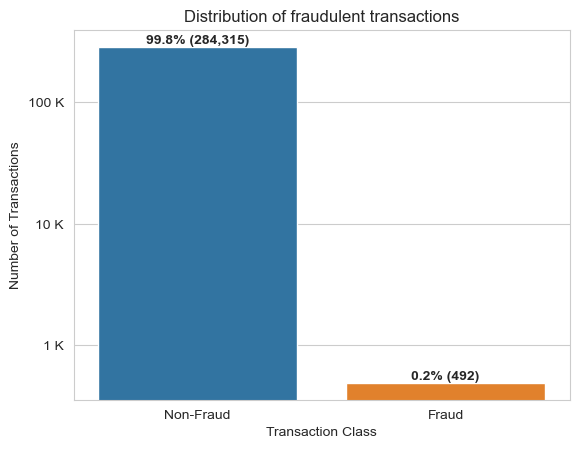

In [11]:
# Create a pandas dataframe with only the Class column
fraud_df = df.select("Class").toPandas()

# Count the number of transactions for each class (fraudulent or not)
fraud_counts = fraud_df['Class'].value_counts()

# Calculate the percentage and absolute number of each class
fraud_perc = fraud_counts / fraud_counts.sum() * 100
fraud_abs = fraud_counts.values

# Create a bar plot with logarithmic y-axis
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.yscale('log')

# Add percentage and absolute value labels to the bars
for i, v in enumerate(fraud_counts):
    plt.text(i, v, f"{fraud_perc[i]:.1f}% ({fraud_abs[i]:,})", ha='center', va='bottom', fontweight='bold')

# Set the y-axis labels and formatter
plt.ylabel('Number of Transactions')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f} K'.format(x/1000)))

# Set the axis labels and title
plt.xlabel('Transaction Class')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.title('Distribution of fraudulent transactions')

plt.show()

As mentioned earlier, the majority of transactions are legitimate. If we use this dataset as the foundation for our predictive models and analysis, we may encounter many errors, and our algorithms are likely to overfit since they will "presume" that most transactions are not fraudulent. However, we do not want our model to presume; we want our model to identify patterns that indicate fraud.



### 1.2.2 Amount -- Should we remove this? At least for me, doesnt make much sense.

In [12]:
# create a function to group time values
@f.udf(returnType=t.StringType())
def time_udf(time):
    if time < 50000:
        return "Under 50K s"
    elif 50000 <= time <= 100000:
        return "Between 50K and 100K s"
    elif time > 100000:
        return "Over 100K s"
    else:
        return "NA"

# apply the function to the "Time" column
df = df.withColumn('time_udf', time_udf('Time'))

df.limit(10).toPandas()

Py4JJavaError: An error occurred while calling o351.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 23.0 failed 1 times, most recent failure: Lost task 0.0 in stage 23.0 (TID 24) (DESKTOP-9VU4VJO.home executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:82)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 25 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3997)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4167)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:526)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4165)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4165)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3994)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:82)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 25 more


In [13]:
# Define window function with partitionBy clause
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Create time group table
time_group_table = df.select("time_udf", "Amount"). \
    groupBy("time_udf"). \
    agg(
    f.count("Amount").alias("UserCount"),
    f.mean("Amount").alias("Amount_Avg"),
    f.min("Amount").alias("Amount_Min"),
    f.max("Amount").alias("Amount_Max")). \
    withColumn("total", f.sum("UserCount").over(window)). \
    withColumn("Percent", f.round(f.col("UserCount")*100 / f.col("total"), 2)). \
    drop("total"). \
    orderBy(f.desc("Percent"))

time_group_table.limit(10).toPandas()


Py4JJavaError: An error occurred while calling o399.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 24.0 failed 1 times, most recent failure: Lost task 0.0 in stage 24.0 (TID 25) (DESKTOP-9VU4VJO.home executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:82)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 27 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:82)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:853)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(Unknown Source)
	at java.net.AbstractPlainSocketImpl.accept(Unknown Source)
	at java.net.PlainSocketImpl.accept(Unknown Source)
	at java.net.ServerSocket.implAccept(Unknown Source)
	at java.net.ServerSocket.accept(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 27 more


In [ ]:
# Convert PySpark dataframe to Pandas dataframe
time_group_df = time_group_table.toPandas()

# Create barplot
ax = sns.barplot(x="time_udf", y="Percent", data=time_group_df)

for p in ax.patches:
    abs_value = p.get_height()
    ax.annotate(f'{abs_value}',
                (p.get_x() + p.get_width() / 2., abs_value),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.title("User Count and Transaction Amount by Time Group")
plt.xlabel("Time Group")
plt.ylabel("Percentage")
plt.show();

In [ ]:
# All Transactions
df_aux = df.select("Class", "Amount").toPandas()

# Define amount ranges
amount_ranges = [
    {"range": "Transaction Value <= $100", "min_amount": 0, "max_amount": 100},
    {"range": "Transaction Value between \$101 and \$2000", "min_amount": 101, "max_amount": 2000},
    {"range": "Transaction Value between \$2001 and \$5000", "min_amount": 2001, "max_amount": 5000},
    {"range": "Transaction Value > $5000", "min_amount": 5001, "max_amount": df_aux["Amount"].max()}
]

# Create four subplots for different amount ranges
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for idx, amount_range in enumerate(amount_ranges):
    row_idx = idx // 2
    col_idx = idx % 2

    # Filter transactions within amount range
    df_range = df_aux[(df_aux["Amount"] > amount_range["min_amount"]) & (df_aux["Amount"] <= amount_range["max_amount"])]

    # Plot histogram
    sns.histplot(data=df_range, x="Amount", ax=axes[row_idx, col_idx], hue="Class", kde=True)
    axes[row_idx, col_idx].set_title(amount_range["range"])
    axes[row_idx, col_idx].set_ylabel("Number of Transactions")
    axes[row_idx, col_idx].legend(labels=["Fraud", "Non-Fraud"])

fig.suptitle("All Transactions", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Only fraud transactions
only_fraud = df.filter(df.Class == 1).select("Amount").toPandas()

# Add a pallet
aux_pal = ["#ff7f7f", "#ff3c3c"]

# Create three subplots for different amount ranges
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Amount range <= 100
sns.histplot(data=only_fraud[only_fraud["Amount"] <= 100], x="Amount", ax=axes[0], kde=True, color=aux_pal[0])
axes[0].set_title("Transaction Amount <= $100")
axes[0].set_ylabel("Number of Transactions")

# Amount range > 100
sns.histplot(data=only_fraud[(only_fraud["Amount"] > 100)], x="Amount", ax=axes[1], kde=True, color=aux_pal[1])
axes[1].set_title("Transaction Amount > $100")
axes[1].set_ylabel("Number of Transactions")

fig.suptitle("Only Fraudulent Transactions", fontsize=16)
plt.tight_layout()
plt.show()

### 1.2.3 Remaining variables

In [ ]:
# create several histograms to show the distributions of the features
fig, axs = plt.subplots(8, 4, figsize=(25, 15))
fig.suptitle("Distribution of Features", fontsize=14)

for col, ax in zip(df.columns, axs.flatten()):
    ax.hist(df.select(col).toPandas()[col])
    ax.grid(False)
    ax.tick_params(axis='x', labelrotation=45, labelsize=14)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(col.upper(), fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.show()

Through the histograms, we can observe that the feature "Time" does not follow a normal distribution, with a lower occurrence in the range of 75,000-100,000 seconds. On the other hand, the features Vx show a normalized distribution centered around the value 0, with some negative values.

## 1.3 Imbalanced Data

To address the imbalanced data issue, we will implement the technique of Random Under Sampling. The aim is to balance the dataset by removing data, which helps to avoid model overfitting.

The following steps will be taken:

    - Determine the degree of imbalance in the class by using the "value_counts()" function on the class column to count the number of instances for each label.

    - Bring the number of non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio),which will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.

    - Shuffle the data to ensure that our models can maintain a certain accuracy every time we run the script.

**Note**: It is important to note that the Random Under Sampling technique may result in a loss of information since we are reducing the number of instances in the dataset.

In [ ]:
# Select fraud and non-fraud transactions and limit non-fraud transactions to the same number as fraud transactions
fraud_df = df.filter(f.col('Class') == 1)
non_fraud_df = df.filter(f.col('Class') == 0).limit(fraud_df.count())

# Combine fraud and non-fraud transactions and shuffle the data
balanced_df = fraud_df.union(non_fraud_df).orderBy(f.rand())

# Show 10 rows of the shuffled, balanced dataframe
balanced_df.limit(10).toPandas()

In [ ]:
# Convert the Spark dataframe to a pandas dataframe
fraud_df = balanced_df.select("Class").toPandas()

# Create a countplot with logarithmic y-axis
sns.countplot(x='Class', data=fraud_df, palette='Set1', order=[1, 0])

# Calculate the percentage of each class
fraud_counts = fraud_df['Class'].value_counts()
fraud_perc = fraud_counts / fraud_counts.sum() * 100

# Set the y-axis labels and formatter
plt.ylabel('Number of Transactions')

# Set the axis labels and title
plt.xlabel('Transaction Class')
plt.xticks([0, 1], ['Fraud', 'Non-Fraud'])
plt.title('Balanced Distribution of Transactions')

plt.show()

Now that we have our dataframe correctly balanced, we can go further with our analysis and data preprocessing.


## Correlations

Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (Balanced) in order for us to see which features have a high positive or negative correlation in regard to fraud transactions.

Summary and Explanation:

    Negative Correlations: V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.
    Positive Correlations: V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.
    BoxPlots: We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.

Note: We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.


In [ ]:
df = df.drop("time_udf")
balanced_df = balanced_df.drop("time_udf")

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(df.toPandas().corr(), cmap='coolwarm_r')
plt.title('Correlations with Unbalanced Data')

plt.subplot(1, 2, 2)
sns.heatmap(balanced_df.toPandas().corr(), cmap='coolwarm_r')
plt.title('Correlations with Balanced Data')

plt.show()

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(balanced_df.toPandas().corr() > 0.7,cbar=False, annot_kws={'size':20})
plt.title('Correlations with Balanced Data > 0.7')

plt.subplot(1, 2, 2)
sns.heatmap(balanced_df.toPandas().corr() < -0.7,cbar=False, annot_kws={'size':20})
plt.title('Correlations with Balanced Data < -0.7')

plt.show();


#### Conclusions from Correlation Matrix
Based on our correlation matrix, we have concluded the following:

- The variables that were a product of PCA are not correlated with each other, meaning they are independent.
- The variable "Time" seems to be negatively correlated with all of the "Vx" variables, which means that as "Time" increases, the values of "Vx" decrease, and vice versa.
- The variables "Time" and "Class" seem to have no correlation, indicating that the time at which a transaction occurs has no influence on whether it is fraudulent or not.
- The variable "Class" seems to be negatively correlated with some of the "Vx" variables, indicating that certain values of "Vx" are more likely to be associated with fraudulent transactions, while not correlated at all with others.


## Distributions: Univariate

In [ ]:
# select all columns except the ones to exclude
cols_to_include = [col for col in balanced_df.columns if col not in ['Time']]
df_to_plot = balanced_df.select(*cols_to_include)

for col in df_to_plot.columns:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # plot histogram
    axs[0].hist(df_to_plot.select(col).rdd.flatMap(lambda x: x).collect(), bins=50)
    axs[0].set_title(f"Distribution of {col} values", size=14)
    axs[0].set_xlabel(col, size=12)
    axs[0].set_ylabel("Count", size=12)

    # plot boxplot
    sns.boxplot(data=df_to_plot.select(col).toPandas(), x=col, ax=axs[1])
    axs[1].set_title(f"{col} Boxplot", size=14)
    axs[1].set_xlabel(col, size=12)
    axs[1].set_ylabel("Count", size=12)

plt.show();

## Distributions: Bivariate

In [ ]:
#Bivariate Analysis

data = df_to_plot.toPandas()
fig, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V14", data=data,  ax=axes[0])
axes[0].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=data,  ax=axes[1])
axes[1].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=data, ax=axes[2])
axes[2].set_title('V10 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V16", data=data, ax=axes[3])
axes[3].set_title('V16 vs Class Negative Correlation')

plt.show()

In [ ]:
fig, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V4", data=data,  ax=axes[0])
axes[0].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V11", data=data,  ax=axes[1])
axes[1].set_title('V11 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=data, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=data, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

In [ ]:
hist_fraud = df_to_plot.filter(f.col('Class') == 1).drop('Class').toPandas()

hist_fraud.hist(bins=30, figsize=(10, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.8)
plt.show()